In [1]:
from platform import python_version

print(python_version())

3.9.2


In [2]:
import os
os.chdir('D:\yahel\phd\courses\ML in biology research\\final_project')
os.getcwd()

'd:\\yahel\\phd\\courses\\ML in biology research\\final_project'

In [3]:


import numpy as np
import pandas as pd
import random
import string
import pickle
import copy
import glob
from functools import partial
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold , train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin

from Diabetic_readmission_essentials import categorize_dia, calculate_ratio
from Diabetic_readmission_essentials import plotsEDA

from imblearn.over_sampling import SMOTENC

random.seed(42)
mpl.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

C:\Users\yahelc\AppData\Local\Temp\ipykernel_22180\131536188.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# read database #
path_to_data = os.path.join('data', 'diabetic_data.csv')
whole_data_df = pd.read_csv(path_to_data)
whole_data_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
# Find for each feature the value it has
possibale_val_list = [whole_data_df[x].unique() for x in whole_data_df.columns]
possibale_val_df = pd.DataFrame(zip(list(whole_data_df.columns),possibale_val_list))
possibale_val_df

,0,1
0,encounter_id,"[2278392, 149190, 64410, 500364, 16680, 35754,..."
1,patient_nbr,"[8222157, 55629189, 86047875, 82442376, 425192..."
2,race,"[Caucasian, AfricanAmerican, ?, Other, Asian, ..."
3,gender,"[Female, Male, Unknown/Invalid]"
4,age,"[[0-10), [10-20), [20-30), [30-40), [40-50), [..."
5,weight,"[?, [75-100), [50-75), [0-25), [100-125), [25-..."
6,admission_type_id,"[6, 1, 2, 3, 4, 5, 8, 7]"
7,discharge_disposition_id,"[25, 1, 3, 6, 2, 5, 11, 7, 10, 4, 14, 18, 8, 1..."
8,admission_source_id,"[1, 7, 2, 4, 5, 6, 20, 3, 17, 8, 9, 14, 10, 22..."
9,time_in_hospital,"[1, 3, 2, 4, 5, 13, 12, 9, 7, 10, 6, 11, 8, 14]"


#### Filter dataset for diabetic pateints diagnosed at least once 

In [6]:
# replace ?/None/Unknown/Invalid  with np.nan
whole_data_df[whole_data_df == "?"] = np.nan
whole_data_df[whole_data_df == "None"] = np.nan
whole_data_df[whole_data_df == "Unknown/Invalid"] = np.nan

# how many var and obs in data, data types and non -missing values
mis = whole_data_df.isna().sum()
whole_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [7]:
# pop out the features with 1 option only
for fiture in whole_data_df[whole_data_df.columns[2:]]:
    if len(set(whole_data_df[fiture])) == 1:
        whole_data_df.pop(fiture)
    elif mis[fiture] > len(whole_data_df):
        whole_data_df.pop(fiture)

In [8]:
diagnosis_cols_list = ['diag_' + str(num) for num in [1,2,3]]

# Regex pattern to locate diabeteic pateints 
pattern = r'250(\.\d{2})?'

# count diabetes diagnosis appearance  in all 3 daignosis columns 
diag_count = whole_data_df[diagnosis_cols_list].apply(lambda x: x.str.contains(pattern)).sum(axis =1)

diabetic_only_df = whole_data_df[diag_count > 0]
print('%d encounters out of %d total encounters are of diabetic pateints \n i.e. ~ %.2f%% '\
    %(diabetic_only_df.shape[0],whole_data_df.shape[0],
      (diabetic_only_df.shape[0]/whole_data_df.shape[0])*100))

C:\Users\yahelc\AppData\Local\Temp\ipykernel_22180\668848931.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  diag_count = whole_data_df[diagnosis_cols_list].apply(lambda x: x.str.contains(pattern)).sum(axis =1)


38024 encounters out of 101766 total encounters are of diabetic pateints 
 i.e. ~ 37.36% 


### determine repeated encounter by the same patient

In [9]:
duplicated_encounters = sum(diabetic_only_df['patient_nbr'].duplicated())
print('%d encounters are patient repeated ones, ~%.2f%%' % \
    (duplicated_encounters,
    (duplicated_encounters/diabetic_only_df.shape[0]*100)))


print(diabetic_only_df['patient_nbr'].value_counts().value_counts())


6836 encounters are patient repeated ones, ~17.98%
count
1     26849
2      3091
3       750
4       242
5       114
6        55
7        31
8        14
10       10
11        9
9         7
15        4
12        2
14        2
17        2
28        1
13        1
18        1
19        1
22        1
38        1
Name: count, dtype: int64


In [10]:
calculate_ratio(diabetic_only_df['readmitted'])

readmitted
NO     0.547102
>30    0.343362
<30    0.109536
Name: count, dtype: float64

In [11]:
# an imbalanced label! 

# get the repeated patients readmission labels 
duplicated_df = diabetic_only_df[diabetic_only_df['patient_nbr'].duplicated()]
duplicated_df = duplicated_df[~duplicated_df['patient_nbr'].duplicated()]

# the precenatge of 
print('\n\nprecenatge of label classes beloning to repeated patients \n',duplicated_df['readmitted'].value_counts()/diabetic_only_df['readmitted'].value_counts())



precenatge of label classes beloning to repeated patients 
 readmitted
<30    0.163745
>30    0.147212
NO     0.083401
Name: count, dtype: float64


## Since a large portion of the encounters is a duplication of the same patient 
## We decided to treat each encounter as a different patient
## Therefore for test-train split we will follow the group_stratified split 

In [12]:
# stratify by pateints' ID as group 
groups_for_stratification = diabetic_only_df['patient_nbr']
X = diabetic_only_df.drop('readmitted',axis=1)
Y = diabetic_only_df['readmitted']

# instentiate the StratifiedGroupKFold class
sgkf = StratifiedGroupKFold(n_splits=5) 

# use the CV split to create 5 spilt of a 80-20 ratio
cv_division = sgkf.split(X, Y,groups_for_stratification)

# unpack the first one - randomly 
train_test_index_array, *_ = cv_division

train_df = diabetic_only_df.iloc[train_test_index_array[0]]
test_df = diabetic_only_df.iloc[train_test_index_array[1]]

display(pd.DataFrame({'Complete dataset' : calculate_ratio(diabetic_only_df['readmitted']),
                      'Train datset (80%)' : calculate_ratio(train_df['readmitted']),
                      'Test datset (20%)' : calculate_ratio(test_df['readmitted'])}))

print('There are %d pateint with overlap between train-test cohorts' % sum(np.in1d(train_df['patient_nbr'].unique(), test_df['patient_nbr'].unique())))

#if len(glob.glob('D:/yahel/phd/courses/ML in biology research/final_project/data/data_split*.csv')) == 0:
#    train_df.to_csv(os.path.join(os.getcwd(),'data','data_split','train_cohort.csv'))
#    test_df.to_csv(os.path.join(os.getcwd(),'data','data_split','test_cohort.csv'))

,Complete dataset,Train datset (80%),Test datset (20%)
readmitted,,,
NO,0.547102,0.547107,0.547080
>30,0.343362,0.343360,0.343372
<30,0.109536,0.109533,0.109548


There are 0 pateint with overlap between train-test cohorts


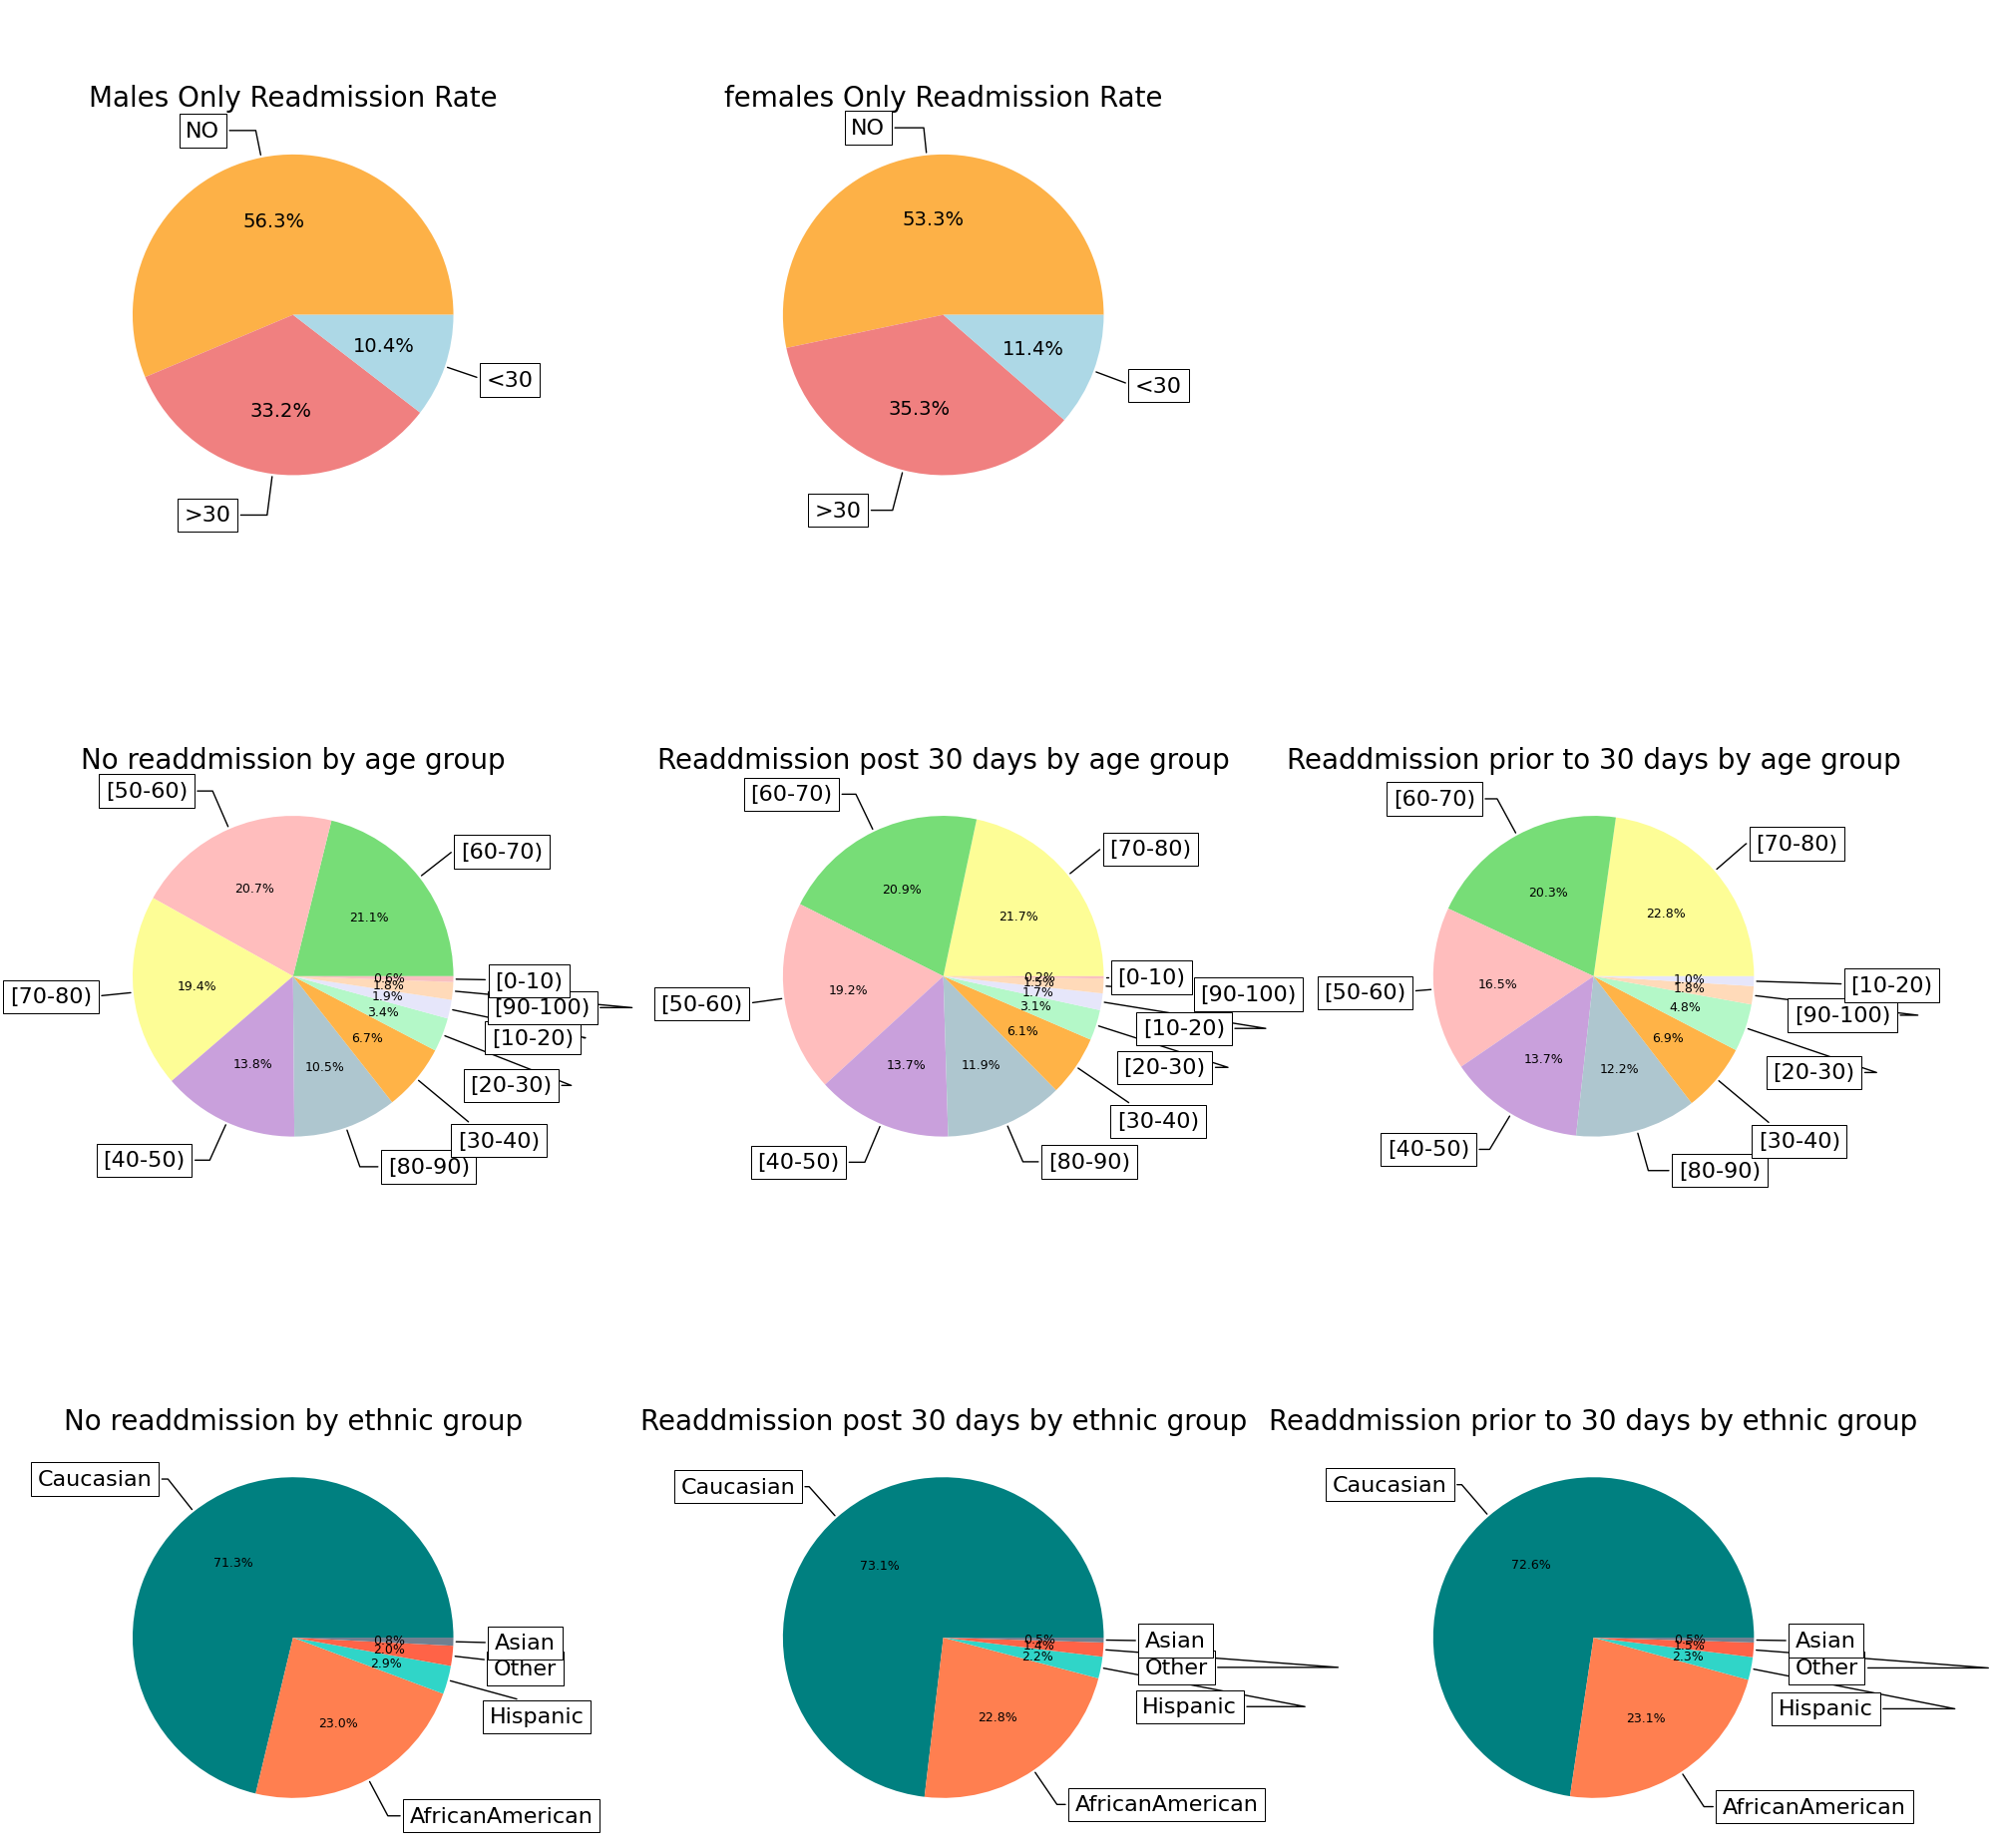

In [13]:
# plot pie charts for labels across different stratifications 
eda_plots = plotsEDA()

# run a for loop to plot all possible pie charts we had in mind #

# set lyaout of plots #
n_charts = 8

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()
for i in range(n_charts):
    # Prepare your data for each subplot
    # for Gender pie charts
    if i < 2:
        filtered_data = train_df[train_df['gender'] == ('Male' if i % 2 == 0 else 'Female')]
        rate = filtered_data['readmitted'].value_counts()

        # set title
        if i % 2 == 0:
            title = 'Males Only Readmission Rate'
        else:
            title = 'females Only Readmission Rate'
               
        eda_plots.plot_pie_chart(data=rate, ax=axs[i], title=title,
                                 title_font_size=20, annotation_font_size=16, pie_font_size=14,
                                 annotation_offsets=[(0.3,0.2)])
    elif i < 5:
        if i % 3 == 0:
            filtered_data = train_df[train_df['readmitted'].isin(['>30'])]
            rate = filtered_data['age'].value_counts()
            title = 'Readdmission post 30 days by age group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#fdfd96','#77dd77','#ffbdbd','#c9a0dc','#aec6cf','#ffb347',
                                            '#b4f8c8','#e6e6fa','#ffdab9','#f9c0c0'],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.7),
                                                        (0.2,1),(0.3,1.2),(0.7,1),(0.1,0),(0.3,0)])
        elif i < 3:
            filtered_data = train_df[train_df['readmitted'].isin(['NO'])]
            rate = filtered_data['age'].value_counts()
            title = 'No readdmission by age group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#77dd77','#ffbdbd','#fdfd96','#c9a0dc','#aec6cf','#ffb347',
                                            '#b4f8c8','#e6e6fa','#ffdab9','#f9c0c0'],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.7),
                                                        (0.2,1),(0.3,1),(0.3,1.3),(0.3,0.7),(0.3,0)])
        else:
            filtered_data = train_df[train_df['readmitted'].isin(['<30'])]
            rate = filtered_data['age'].value_counts()
            title = 'Readdmission prior to 30 days by age group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#fdfd96','#77dd77','#ffbdbd','#c9a0dc','#aec6cf','#ffb347',
                                            '#b4f8c8','#ffdab9','#e6e6fa',],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.2,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.7),
                                                        (0.2,1),(0.3,1.2),(0.7,1),(0.1,0),(0.3,0)])
    else:
        if i % 3 == 0:
            filtered_data = train_df[train_df['readmitted'].isin(['>30'])]
            rate = filtered_data['race'].value_counts()
            title = 'Readdmission post 30 days by ethnic group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#008080','#FF7F50','#30D5C8','#FF6347','#708090'],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.3,1.5),(0.3,1.7),(0.3,0.3)])
        elif i < 6:
            filtered_data = train_df[train_df['readmitted'].isin(['NO'])]
            rate = filtered_data['race'].value_counts()
            title = 'No readdmission by ethnic group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#008080','#FF7F50','#30D5C8','#FF6347','#708090'],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.3,1),(0.3,0.8),(0.3,0.3)])
        else:
            filtered_data = train_df[train_df['readmitted'].isin(['<30'])]
            rate = filtered_data['race'].value_counts()
            title = 'Readdmission prior to 30 days by ethnic group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#008080','#FF7F50','#30D5C8','#FF6347','#708090'],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.2,1.5),(0.3,1.7),(0.3,0.3)])

axs[2].axis('off') # remove emplt graph

plt.tight_layout()  # Adjust the layout so everything fits without overlapping
plt.show()

#eda_plots.plot_pie_chart(data=males_only_rate, title='Males Only Readmission Rate', 
                         #title_font_size=20, annotation_font_size=16, pie_font_size=16)

d:\yahel\phd\courses\ML in biology research\final_project\Diabetic_readmission_essentials.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x, y=y, palette=colors, showmeans=showmeans, meanprops=meanprops, ax=ax)
d:\yahel\phd\courses\ML in biology research\final_project\final_project_ml\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\yahel\phd\courses\ML in biology research\final_project\final_project_ml\lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_

(0.0, 1.0, 0.0, 1.0)

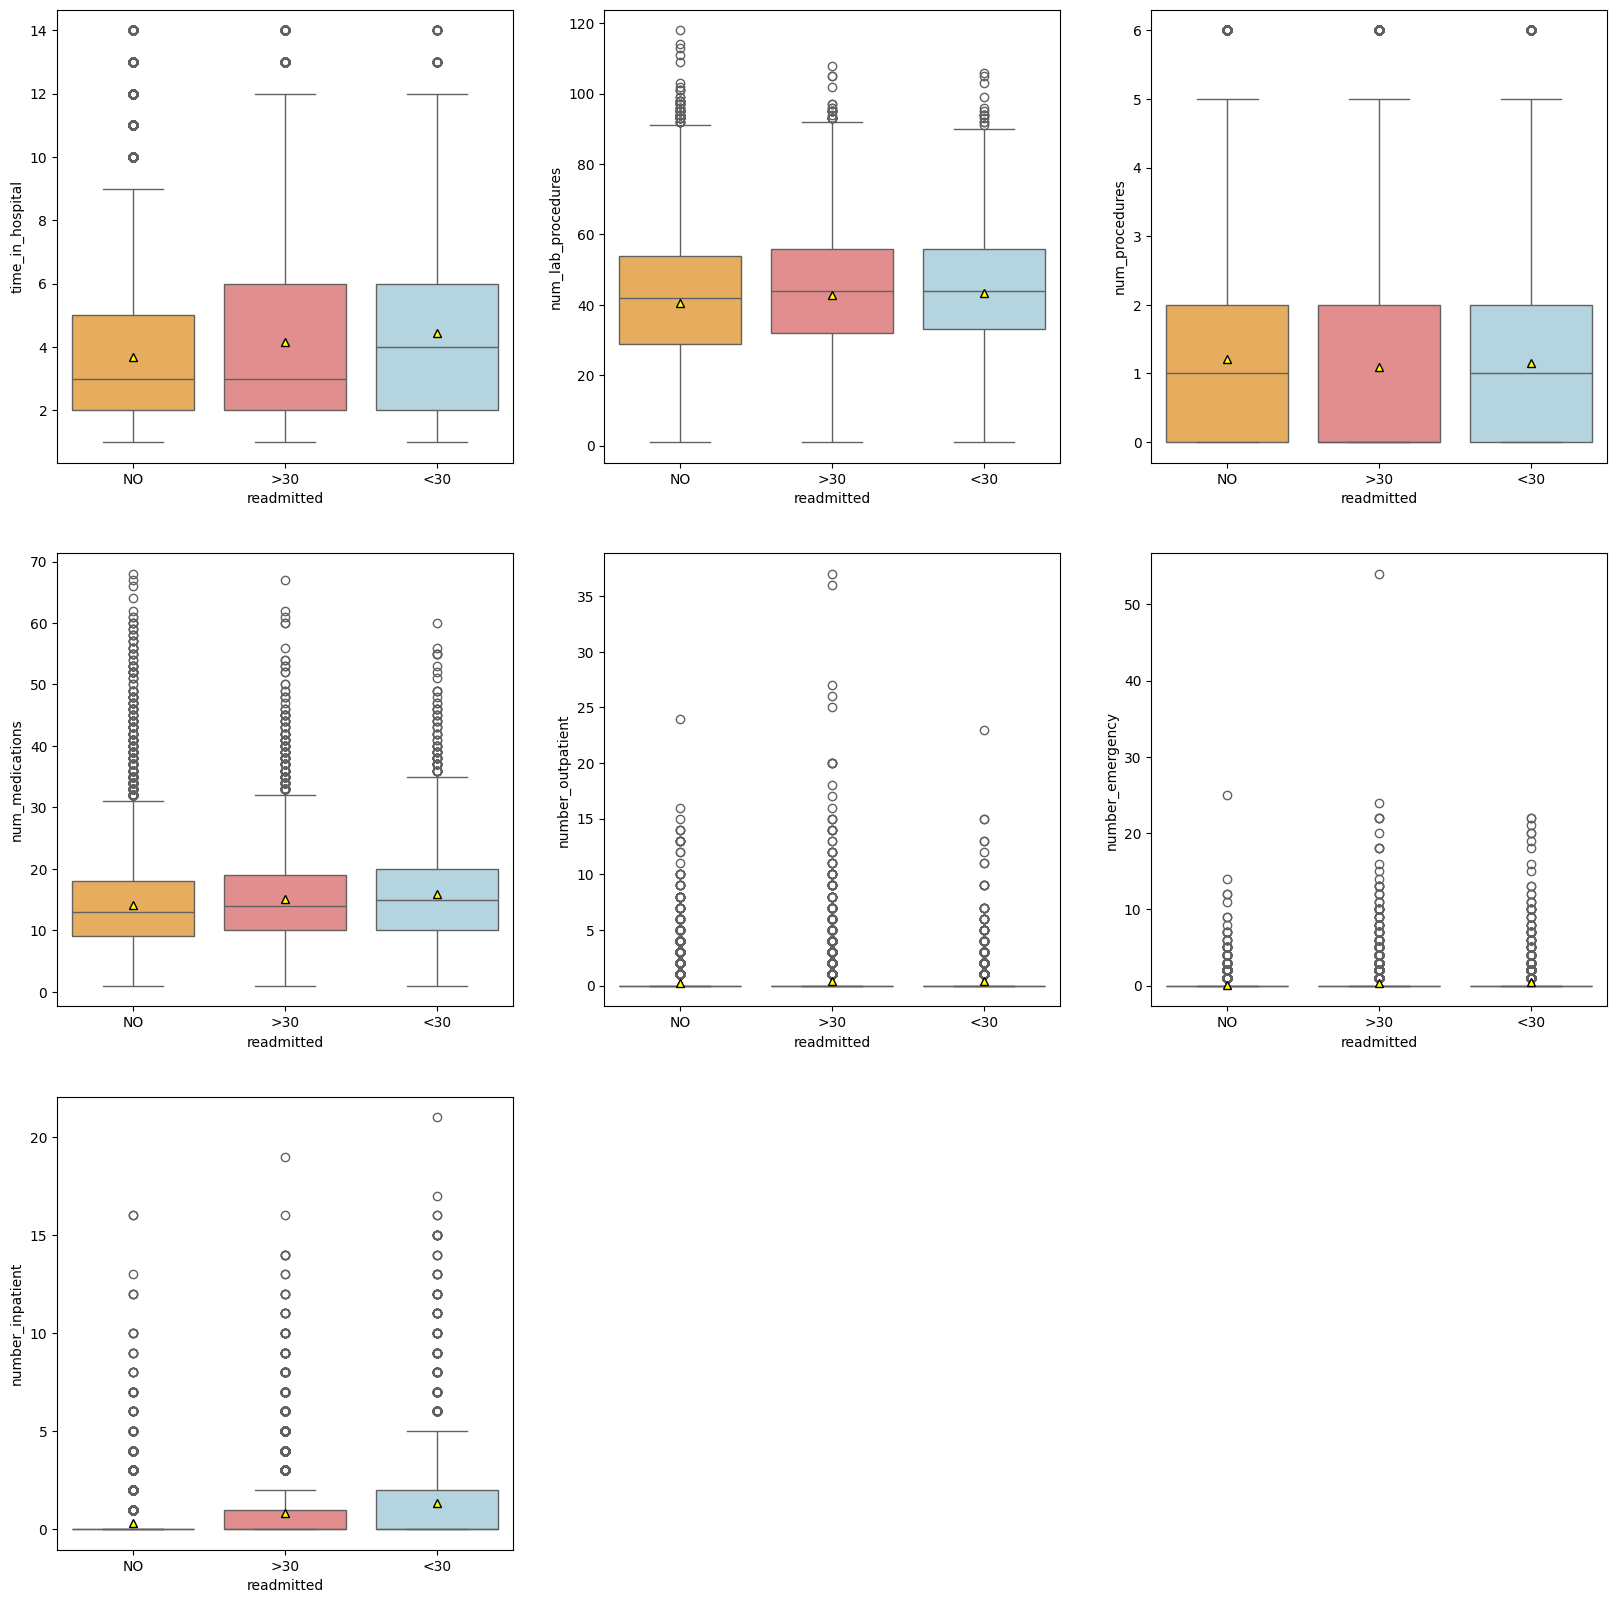

In [14]:
train_df.columns
num_features = ['time_in_hospital','num_lab_procedures','num_procedures',
                'num_medications','number_outpatient','number_emergency','number_inpatient']

# run a for loop to plot all possible numerical values compared to label #

# set lyaout of plots #
n_charts = 7

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()
for i,num in enumerate(num_features):
    eda_plots.plot_boxplot(train_df,x='readmitted', y=num,ax=axs[i])

axs[8].axis('off') ; axs[7].axis('off') # remove empty plots

In [15]:
# add new columns for diagnosis categories 

train_df['diag_1_cat'] = train_df['diag_1'].apply(categorize_dia)
train_df['diag_2_cat'] = train_df['diag_2'].apply(categorize_dia)
train_df['diag_3_cat'] = train_df['diag_3'].apply(categorize_dia)

# loop over different diagnosis save diabetes and append thier labels

disease_list = {'Other','Circulatory','Respiratory','Digestive','Injury',
                'Musculoskeletal','Genitourinary','Neoplasms'}
stacked_bx_df = None
n_patients_per_disease = []
for key in disease_list:
    disease_patient_filter = train_df[['diag_1_cat','diag_2_cat','diag_3_cat']].apply(lambda x: x.isin([key]).sum(), axis = 1) > 0
    
    # get label for pateint who was diagnosed at least once with the disease
    disease_subset = train_df['readmitted'][disease_patient_filter].reset_index(drop = False)['readmitted']
    
    # keep the total number pf pateints diagnosed 
    n_patients_per_disease.append(len(disease_subset))
    
    # normalize to number of disease diagnosis to get ratio of labels within each disease
    disease_subset = disease_subset.value_counts()/ len(disease_subset)
        
    if stacked_bx_df is None:
        stacked_bx_df = pd.DataFrame({key : disease_subset})
    else:
        stacked_bx_df = stacked_bx_df.merge(pd.DataFrame({key : disease_subset}),
                                            left_index=True,right_index=True)
         
stacked_bx_df

C:\Users\yahelc\AppData\Local\Temp\ipykernel_22180\1178890869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['diag_1_cat'] = train_df['diag_1'].apply(categorize_dia)
C:\Users\yahelc\AppData\Local\Temp\ipykernel_22180\1178890869.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['diag_2_cat'] = train_df['diag_2'].apply(categorize_dia)
C:\Users\yahelc\AppData\Local\Temp\ipykernel_22180\1178890869.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,Injury,Other,Genitourinary,Digestive,Neoplasms,Respiratory,Musculoskeletal,Circulatory
readmitted,,,,,,,,
NO,0.552044,0.541321,0.507669,0.535324,0.630975,0.531564,0.608052,0.540632
>30,0.318801,0.343366,0.376994,0.348174,0.259082,0.372355,0.298139,0.349622
<30,0.129155,0.115313,0.115337,0.116502,0.109943,0.096080,0.093809,0.109746


Text(0.5, 1.0, 'Readmission rate per label across diagnoses')

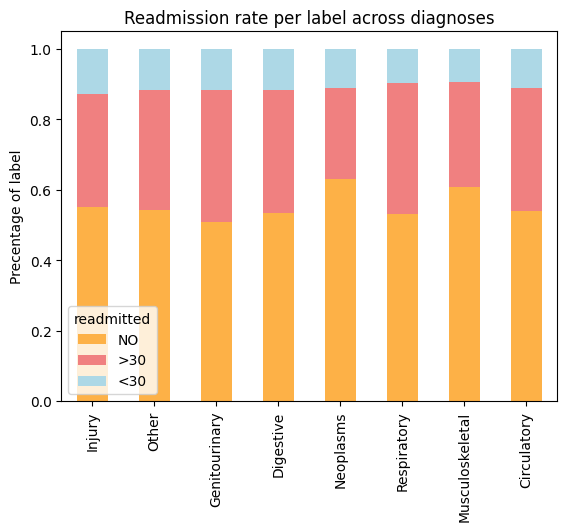

In [16]:
stacked_bx_df.T.plot(kind='bar', stacked=True,
                     color=['#fdb147', 'lightcoral', 'lightblue'])

plt.ylabel('Precentage of label')
 
# title of plot
plt.title('Readmission rate per label across diagnoses')